In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
from transformers import BertTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
import spacy
from nltk.tokenize import word_tokenize
import nltk
import tempfile
import os
from sklearn.model_selection import train_test_split
import time
import logging
import os
import sys
import pandas as pd
import numpy as np
import time
from nltk.corpus import stopwords
from nltk.util import ngrams
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler


import nltk

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the JSON file into a pandas DataFrame
documents_df = pd.read_json('/Users/emanueleferrari/Desktop/_ K10 Downloader/sp500_ten_year_dictionaries.json')
documents_df.sample()

,form,file_number,form_link,attachments_link,index_link,interactive_elements_link,year,quarter,filing_date,CIK,company_name,document_df
2282,10-K,0001120193-18-000003,https://www.sec.gov/Archives/edgar/data/112019...,{'2-EXHIBIT 12.1-EX-12.1': 'https://www.sec.go...,https://www.sec.gov/Archives/edgar/data/112019...,https://www.sec.gov/cgi-bin/viewer?action=view...,2017,full year,2018-02-28,1120193,"NASDAQ, INC.","[{'id': -1.0, 'sub_id': 0, 'chunk_id': 0, 'par..."


In [3]:
# Convert each dictionary in 'document_df' back into a DataFrame
df_list = [pd.DataFrame(d) for d in documents_df['document_df']]

# Concatenate all the DataFrames
flat_df = pd.concat(df_list, ignore_index=True)

print(print(flat_df.shape))
flat_df.sample()


(3890395, 18)
None


,id,sub_id,chunk_id,parent_id,type,text,marked_text,item,title_level,token_count,word_count,char_count,bold_all,bold_start,bold_has_any,italic_all,italic_start,italic_has_any
2843171,357.0,0,0,355,NarrativeText,"(a) On October 23, 2014, we announced that the...","(a) On October 23, 2014, we announced that the...",Item 5,2.0,364,277,1657,False,False,False,False,False,True


In [4]:
print(flat_df['type'].value_counts())
# remove type: table, image
flat_df_notab = flat_df[flat_df['type'].isin(['table', 'image']) == False]
print()
print(flat_df_notab['type'].value_counts())

type
NarrativeText    2480305
title             620219
table             361140
list              348123
ItemMarker         72718
image               7890
Name: count, dtype: int64

type
NarrativeText    2480305
title             620219
list              348123
ItemMarker         72718
Name: count, dtype: int64


In [5]:
token_estimator_df = flat_df_notab[['text', 'token_count']]

# remove rows with NaN in 'text' column
token_estimator_df = token_estimator_df.dropna(subset=['text'])  
# remove rows with empty string, whitespace, or new line only in 'text' column
token_estimator_df = token_estimator_df[token_estimator_df['text'].str.strip() != '']  
# sample 1_000_000 rows
token_estimator_df = token_estimator_df.sample(1_000_000, random_state=3362)


print(token_estimator_df.shape)

(1000000, 2)


In [6]:
empty_texts = token_estimator_df[token_estimator_df['text'].apply(lambda x: x.strip()) == '']
print(f'Number of empty/whitespace-only texts: {len(empty_texts)}')
empty_texts

Number of empty/whitespace-only texts: 0


,text,token_count


In [7]:
# Compile the regular expression patterns
pattern_count_punctuation = re.compile(r'[.,;:!?]')
pattern_count_spaces = re.compile(r'[ ]')
pattern_count_quotation_marks = re.compile(r'[\'"‘’“”]')
pattern_count_special_chars = re.compile(r'[^a-zA-Z0-9]')


def count_punctuation(text, pattern=pattern_count_punctuation):
    return len(pattern.findall(text))

def count_spaces(text, pattern=pattern_count_spaces):
    return len(pattern.findall(text))

def count_quotation_marks(text, pattern=pattern_count_quotation_marks):
    return len(pattern.findall(text))

def count_special_chars(text, pattern=pattern_count_special_chars):
    special_chars = pattern.findall(text)
    total_count = len(special_chars)
    unique_count = len(set(special_chars))  # No change here as set requires a full sequence
    return total_count, unique_count

def add_spaces_around_special_chars(text):
    text = re.sub(r'(\W)', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def calculate_variables(df, log_time=False):
    df = df.copy()
    time_df = pd.DataFrame(columns=['step', 'time for 1000 samples'])
    total_time = 0

    steps = [
        ('char_count', lambda df: list(map(len, df['text']))),
        ('spaces_count', lambda df: df['text'].apply(count_spaces)),
        ('punctuation_count', lambda df: df['text'].apply(count_punctuation)),
        ('quotation_marks_count', lambda df: df['text'].apply(count_quotation_marks)),
        ('special_char_counts', lambda df: df['text'].apply(count_special_chars)),
        ('word_mean_len_estim', lambda df: df['char_count'] / (df['spaces_count']+1)),

        ('word_list', lambda df: list(map(str.split, df['text']))),
        ('word_count', lambda df: df['word_list'].str.len()),
        ('unique_word_count', lambda df: df['word_list'].apply(lambda x: len(set(w for w in x)))),
        ('average_word_length', lambda df: df['word_list'].apply(lambda x: np.mean([len(w) for w in x]) if x else np.nan)),
        ('bigram_count', lambda df: df['word_list'].apply(lambda x: len(list(ngrams(x, 2))) if x else 0)),
        ('trigram_count', lambda df: df['word_list'].apply(lambda x: len(list(ngrams(x, 3))) if x else 0)),
        
        ('sentence_count', lambda df: df['text'].apply(nltk.sent_tokenize).str.len()),
    ]

    for step, func in steps:
        start = time.time()

        df[step] = func(df)

        elapsed = time.time() - start
        total_time += elapsed
        time_df.loc[len(time_df)] = {'step': step, 'time for 1000 samples': elapsed}
        if log_time:
            print(f'{step:<30} {elapsed:.4f} seconds')

    df['special_char_count'], df['unique_special_char_count'] = zip(*df['special_char_counts'])
    df = df.drop(columns=['special_char_counts'])

    time_df['percentage'] = time_df['time for 1000 samples'] / total_time * 100
    time_df['time for 1000 samples'] = time_df['time for 1000 samples'].apply(lambda x: x/len(df)/1000)
    time_df = time_df[['step', 'time for 1000 samples', 'percentage']]
    time_df = time_df.set_index('step')
    return df, time_df

start_time = time.time()
te_df_regular, preprocessing_time_df = calculate_variables(token_estimator_df, True)
total_time = time.time() - start_time
print(f"Total time: {total_time} seconds")
print(f"Time per 1000 texts: {total_time / (len(token_estimator_df) / 1000)} seconds")
display(preprocessing_time_df)
display(te_df_regular.head())

char_count                     3.9650 seconds
spaces_count                   4.4474 seconds
punctuation_count              5.4073 seconds
quotation_marks_count          5.0541 seconds
special_char_counts            9.6726 seconds
word_mean_len_estim            0.0080 seconds
word_list                      56.8192 seconds
word_count                     0.3019 seconds
unique_word_count              4.6176 seconds
average_word_length            7.5515 seconds
bigram_count                   3.9095 seconds
trigram_count                  4.1369 seconds
sentence_count                 58.8756 seconds
Total time: 197.3360390663147 seconds
Time per 1000 texts: 0.1973360390663147 seconds


,time for 1000 samples,percentage
step,,
char_count,3.964959e-09,2.406409
spaces_count,4.447362e-09,2.699188
punctuation_count,5.407285e-09,3.281784
quotation_marks_count,5.054141e-09,3.067454
special_char_counts,9.672565e-09,5.870463
word_mean_len_estim,8.038044e-12,0.004878
word_list,5.681923e-08,34.484668
word_count,3.019280e-10,0.183246
unique_word_count,4.617615e-09,2.802518


,text,token_count,char_count,spaces_count,punctuation_count,quotation_marks_count,word_mean_len_estim,word_list,word_count,unique_word_count,average_word_length,bigram_count,trigram_count,sentence_count,special_char_count,unique_special_char_count
2811423,(3)Includes legal settlement expense of $141.2...,31,115,16,7,0,6.764706,"[(3)Includes, legal, settlement, expense, of, ...",17,16,5.823529,16,15,1,26,6
1672432,FCX performs a comprehensive review of its env...,27,183,24,1,0,7.320000,"[FCX, performs, a, comprehensive, review, of, ...",25,23,6.360000,24,23,1,25,2
2591110,- Filed herewith,4,16,2,0,0,5.333333,"[-, Filed, herewith]",3,3,4.666667,2,1,1,3,2
867307,"Special charges, net",4,20,2,1,0,6.666667,"[Special, charges,, net]",3,3,6.000000,2,1,1,3,2
153660,"February 28, 2018",4,17,2,1,0,5.666667,"[February, 28,, 2018]",3,3,5.000000,2,1,1,3,2


In [8]:
# def count_punctuation(text):
#     return len(re.findall(r'[.,;:!?]', text))

# def count_spaces(text):
#     return len(re.findall(r'[ ]', text))

# def count_quotation_marks(text):
#     return len(re.findall(r'[\'"‘’“”]', text))

# def count_special_chars(text):
#     special_chars = re.findall(r'[^a-zA-Z0-9]', text)
#     total_count = len(special_chars)
#     unique_count = len(set(special_chars))
#     return total_count, unique_count

# def add_spaces_around_special_chars(text):
#     text = re.sub(r'(\W)', r' \1 ', text)
#     text = re.sub(r'\s+', ' ', text)
#     return text.strip()


# def calculate_variables(df, log_time=False):
#     df = df.copy()

#     if log_time: start = time.time()
#     df['char_count'] = list(map(len, df['text']))
#     if log_time: print(f'char_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['spaces_count'] = df['text'].apply(count_spaces)
#     if log_time: print(f'spaces_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['punctuation_count'] = df['text'].apply(count_punctuation)
#     if log_time: print(f'punctuation_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['quotation_marks_count'] = df['text'].apply(count_quotation_marks)
#     if log_time: print(f'quotation_marks_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['special_char_count'], df['unique_special_char_count'] = zip(*df['text'].apply(count_special_chars))
#     if log_time: print(f'special_char_count done in {time.time() - start} seconds')
    
#     # if log_time: start = time.time()
#     # df['text'] = df['text'].apply(add_spaces_around_special_chars)
#     # if log_time: print(f'add_spaces_around_special_chars done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['word_list'] = list(map(str.split, df['text']))
#     if log_time: print(f'word_list done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['word_count'] = df['word_list'].str.len()
#     if log_time: print(f'word_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['word_mean_len_estim'] = df['char_count'] / df['whitespace_count']
#     if log_time: print(f'word_mean_len_estim done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['unique_word_count'] = df['word_list'].apply(lambda x: len(set(w for w in x)))
#     if log_time: print(f'unique_word_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['average_word_length'] = df['word_list'].apply(lambda x: np.mean([len(w) for w in x]) if x else np.nan)
#     if log_time: print(f'average_word_length done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['bigram_count'] = df['word_list'].apply(lambda x: len(list(ngrams(x, 2))) if x else 0)
#     if log_time: print(f'bigram_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['trigram_count'] = df['word_list'].apply(lambda x: len(list(ngrams(x, 3))) if x else 0)
#     if log_time: print(f'trigram_count done in {time.time() - start} seconds')

#     if log_time: start = time.time()
#     df['sentence_count'] = df['text'].apply(nltk.sent_tokenize).str.len()
#     if log_time: print(f'sentence_count done in {time.time() - start} seconds')

#     return df

# start_time = time.time()
# te_df_regular = calculate_variables(token_estimator_df, True)
# total_time = time.time() - start_time
# print(f"Total time: {total_time} seconds")
# print(f"Time per 1000 texts: {total_time / (len(token_estimator_df) / 1000)} seconds")
# te_df_regular.head()

In [9]:
print(te_df_regular.columns)
XY = te_df_regular[['token_count', 'text',  
                     'char_count', 'punctuation_count','spaces_count', 'quotation_marks_count', 
                     'special_char_count', 'unique_special_char_count',
                     'word_count', 'word_mean_len_estim', 
                     'unique_word_count','average_word_length', 'bigram_count', 'trigram_count',
                     'sentence_count' ]]


Index(['text', 'token_count', 'char_count', 'spaces_count',
       'punctuation_count', 'quotation_marks_count', 'word_mean_len_estim',
       'word_list', 'word_count', 'unique_word_count', 'average_word_length',
       'bigram_count', 'trigram_count', 'sentence_count', 'special_char_count',
       'unique_special_char_count'],
      dtype='object')


In [10]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['char_count', 'punctuation_count','spaces_count', 'quotation_marks_count', 
                                   'special_char_count', 'unique_special_char_count', 'word_mean_len_estim', 
                                   'word_count', 'unique_word_count','average_word_length', 'bigram_count', 'trigram_count',
                                   'sentence_count' ]),
    ])

# Extract features and target
X = XY[['text',
         'char_count', 'punctuation_count','spaces_count', 'quotation_marks_count', 
         'special_char_count', 'unique_special_char_count', 'word_mean_len_estim', 
         'word_count', 'unique_word_count','average_word_length', 'bigram_count', 'trigram_count',
         'sentence_count' ]]
y = XY['token_count']

# Split the data into training, validation, and test sets
X_train_val, X_test_df, y_train_val, y_test = train_test_split(X, y, test_size=0.10)
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85)


X_test = X_test_df.drop(columns=['text'])
X_train = X_train_df.drop(columns=['text'])
X_val = X_val_df.drop(columns=['text'])



In [11]:
print('X train shape:', X_train.shape)
print('X val shape:', X_val.shape)
print('X test shape:', X_test.shape)

X train shape: (741176, 13)
X val shape: (158824, 13)
X test shape: (100000, 13)


In [12]:
from transformers import BertTokenizer
import sentencepiece as spm
from nltk.tokenize import word_tokenize
from bpemb import BPEmb
import spacy
from tokenizers import Tokenizer, models



# Initialize tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bpe_tokenizer = Tokenizer(models.BPE()) 
sp_tokenizer = spm.SentencePieceProcessor()
# nlp = spacy.load('en_core_web_sm')

# Define token count functions
def bert_token_count(text):
    return len(bert_tokenizer.tokenize(text))

# def bpe_token_count(text):
#     return len(bpe_tokenizer.encode(text).tokens)

def sp_token_count(text):
    return len(sp_tokenizer.encode_as_pieces(text))

def spacy_token_count(text):
    return len([token.text for token in nlp(text)])

def nltk_token_count(text):
    return len(word_tokenize(text))

# Define tokenizers dictionary
tokenizers = {
    "BERT": bert_token_count,
    # "SentencePiece": sp_token_count,
    "Spacy": spacy_token_count,
    "NLTK": nltk_token_count
}



Processing:   0%|          | 0/3 [00:00<?, ?it/s]

BERT Test R-squared score: 0.9999999980694078
BERT Test Mean Error: 1e-05
BERT Test Root Mean Squared Error: 0.0031622776601683794
BERT Test RMSE for underestimations: 1.0

BERT Maximum underestimation for test data: 1
BERT Maximum overestimation for test data: 0

BERT Prediction time for 1000 instances: 0.8857220506668091 seconds


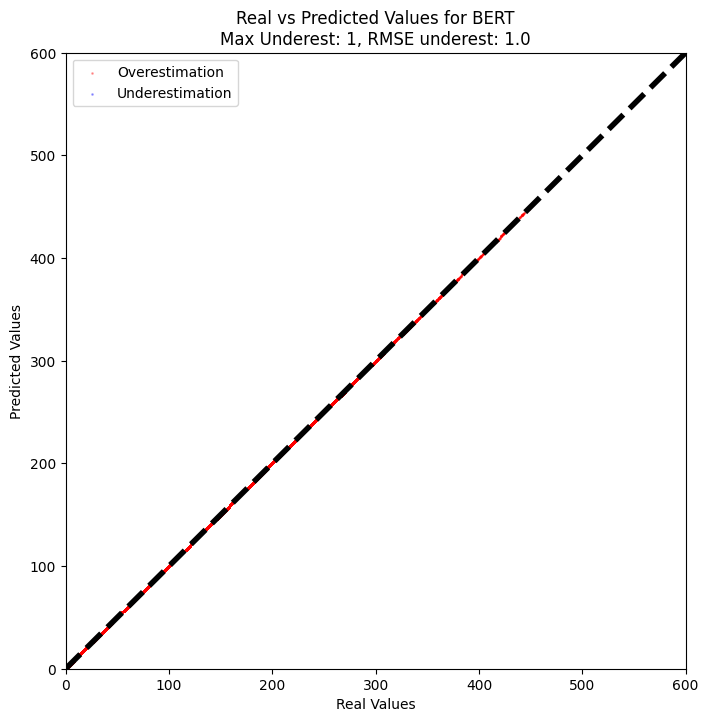

Spacy Test R-squared score: 0.9797670135153445
Spacy Test Mean Error: 6.02069
Spacy Test Root Mean Squared Error: 10.237283331040516
Spacy Test RMSE for underestimations: 11.972972234414623

Spacy Maximum underestimation for test data: 178
Spacy Maximum overestimation for test data: 3

Spacy Prediction time for 1000 instances: 16.788350298404694 seconds


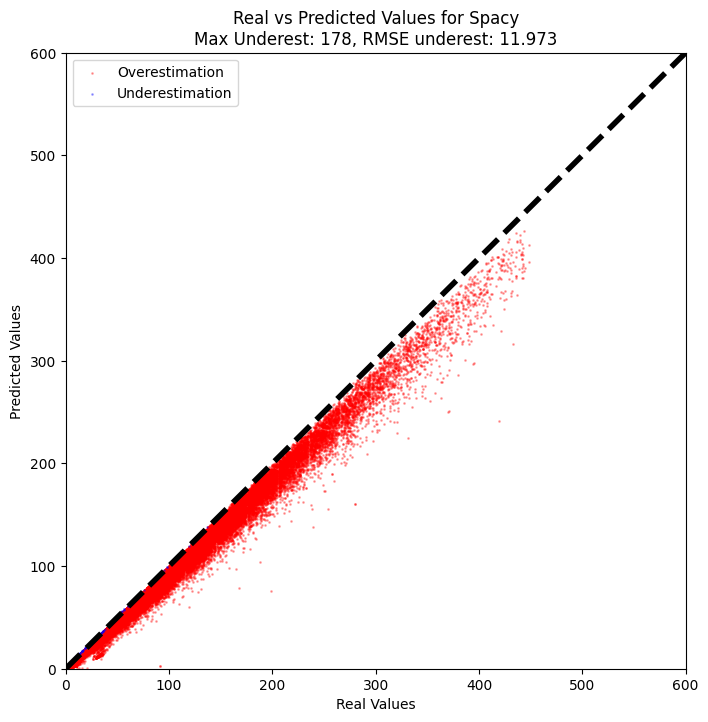

NLTK Test R-squared score: 0.9746388471194599
NLTK Test Mean Error: 6.83449
NLTK Test Root Mean Squared Error: 11.461441008878422
NLTK Test RMSE for underestimations: 13.316240286549466

NLTK Maximum underestimation for test data: 182
NLTK Maximum overestimation for test data: 3

NLTK Prediction time for 1000 instances: 0.17412474155426025 seconds


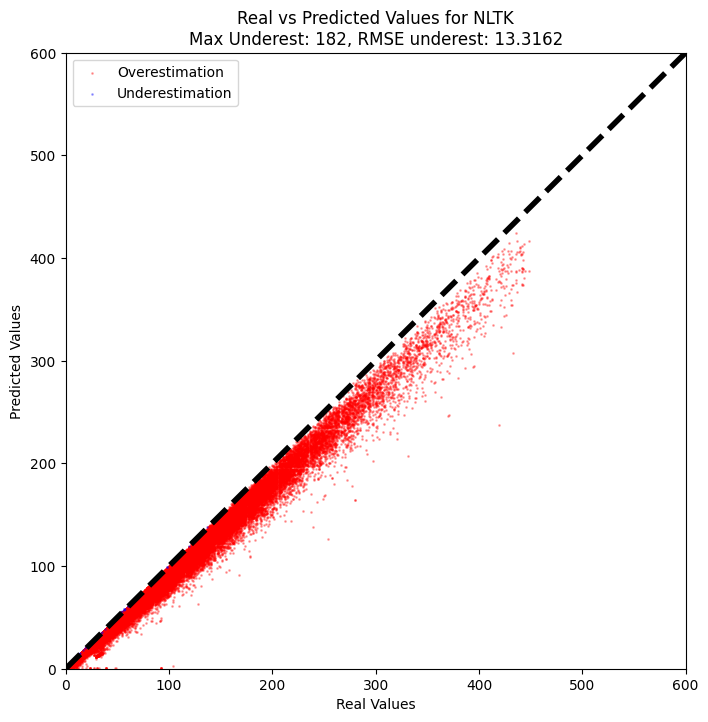

In [13]:
from sentencepiece import SentencePieceTrainer
import numpy as np

def train_tokenizers(tokenizer_dict, X_train, X_test, y_test):
    tokenizer_performance = {}

    pbar = tqdm(tokenizer_dict.items(), desc="Processing") 
    for tokenizer_name, tokenizer in pbar:
        # # Special case for SentencePiece
        # if tokenizer_name == "SentencePiece":
        #     print('Training SentencePiece tokenizer')
        #     # Train SentencePiece on X_train
        #     SentencePieceTrainer.Train(input=X_train.to_string(), model_prefix='m', vocab_size=10000, model_type='bpe')
        #     tokenizer = spm.SentencePieceProcessor(model_file='m.model')

        # Start the timer
        start_time = time.time()

        # Calculate the token count for the test data
        y_test_pred = X_test.apply(tokenizer)

        # Stop the timer
        end_time = time.time()

        # Calculate the prediction time
        prediction_time = end_time - start_time

        # Calculate the R-squared score
        r2_test = r2_score(y_test, y_test_pred)

        # Calculate the Mean Absolute Error (MAE)
        mean_error = (y_test - y_test_pred).mean()

        # Calculate the Root Mean Squared Error (RMSE)
        rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

        # Calculate the RMSE of only the predictions that are less than the real values
        underestimations = y_test_pred < y_test
        rmse_underestimations = sqrt(mean_squared_error(y_test[underestimations], y_test_pred[underestimations]))

        # Calculate the variance of the squared errors
        squared_errors = (y_test - y_test_pred) ** 2
        variance_squared_errors = np.var(squared_errors)
        variance_squared_errors = variance_squared_errors**0.5

        # Calculate the maximum underestimation and overestimation
        underestimation_test = max(y_test - y_test_pred)
        overestimation_test = min(y_test - y_test_pred)*(-1)

        print(f'{tokenizer_name} Test R-squared score: {r2_test}')
        print(f'{tokenizer_name} Test Mean Error: {mean_error}')
        print(f'{tokenizer_name} Test Root Mean Squared Error: {rmse_test}')
        print(f'{tokenizer_name} Test RMSE for underestimations: {rmse_underestimations}')
        print()
        print(f'{tokenizer_name} Maximum underestimation for test data: {underestimation_test}')
        print(f'{tokenizer_name} Maximum overestimation for test data: {overestimation_test}')
        print()
        print(f'{tokenizer_name} Prediction time for 1000 instances: {prediction_time / (len(y_test) / 1000)} seconds')

        # Plot real vs predicted values
        plt.figure(figsize=(8, 8))
        # Create separate scatter plots for overestimations and underestimations
        underestimated = y_test < y_test_pred
        overestimated  = y_test >= y_test_pred
        plt.scatter(y_test[overestimated], y_test_pred[overestimated], color='red', alpha=0.3, s=1, label='Overestimation')
        plt.scatter(y_test[underestimated], y_test_pred[underestimated], color='blue', alpha=0.3, s=1, label='Underestimation')
        # Add the diagonal line
        plt.plot([0, 600], [0, 600], 'k--', lw=4)
        # Add labels and title
        plt.xlabel('Real Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Real vs Predicted Values for {tokenizer_name}\nMax Underest: {int(underestimation_test)}, RMSE underest: {round(rmse_underestimations, 4)}')
        
        # Set the x and y limits
        plt.xlim([0, 600])  # Set the maximum x value to 600
        plt.ylim([0, 600])  # Set the maximum y value to 600
        # Add the legend
        plt.legend()
        # Show the plot
        plt.show()

        # Store the tokenizer performance
        tokenizer_performance[tokenizer_name] = {
            'r2_score': r2_test,
            'underestimation': underestimation_test,
            'overestimation': overestimation_test,
            'prediction_time': prediction_time / (len(y_test) / 1000)
        }

    return tokenizer_performance

tokenizer_performance = train_tokenizers(tokenizers, X_train_df['text'], X_test_df['text'], y_test)

In [14]:
model_dict = {
    "Linear Regression": LinearRegression(),
    # "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(n_estimators=100),
    "Decision Tree": DecisionTreeRegressor(max_depth=20),
    "KNN": KNeighborsRegressor(n_neighbors=128, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(256,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, max_iter=200)
    
}

Processing:   0%|          | 0/5 [00:00<?, ?it/s]

Linear Regression Test R-squared score: 0.9959517953108407
Linear Regression Test Mean Error: -0.0006957307562326044
Linear Regression Test Root Mean Squared Error: 4.579161484646123
Linear Regression Test RMSE for underestimations: 5.591063599357438

Linear Regression Maximum underestimation for test data: 136.84229439196253
Linear Regression Maximum overestimation for test data: 58.74740868117084

Linear Regression Prediction time for 1000 instances: 0.00020352840423583984 seconds


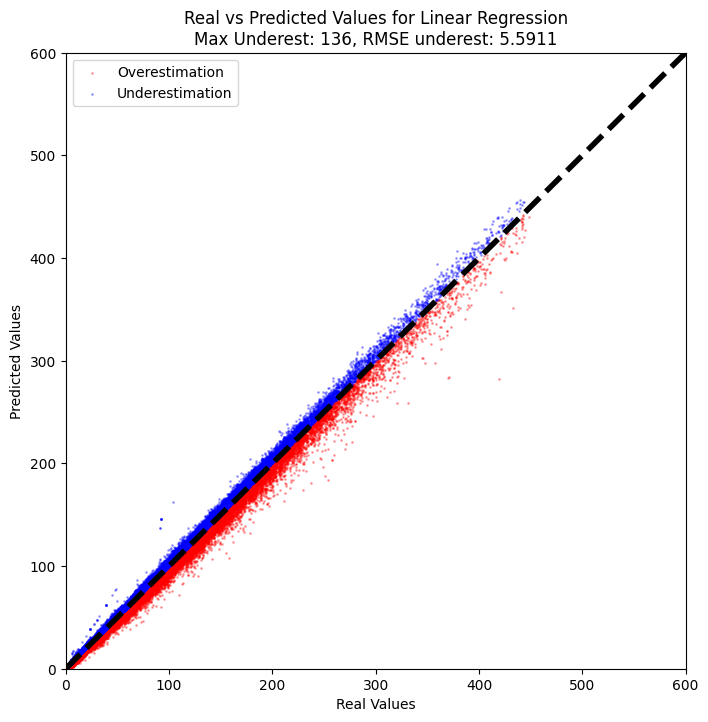

XGBoost Test R-squared score: 0.9959030763441157
XGBoost Test Mean Error: 0.0018805871438980102
XGBoost Test Root Mean Squared Error: 4.606633516074917
XGBoost Test RMSE for underestimations: 5.754206912575281

XGBoost Maximum underestimation for test data: 82.02294921875
XGBoost Maximum overestimation for test data: 59.28045654296875

XGBoost Prediction time for 1000 instances: 0.000324399471282959 seconds


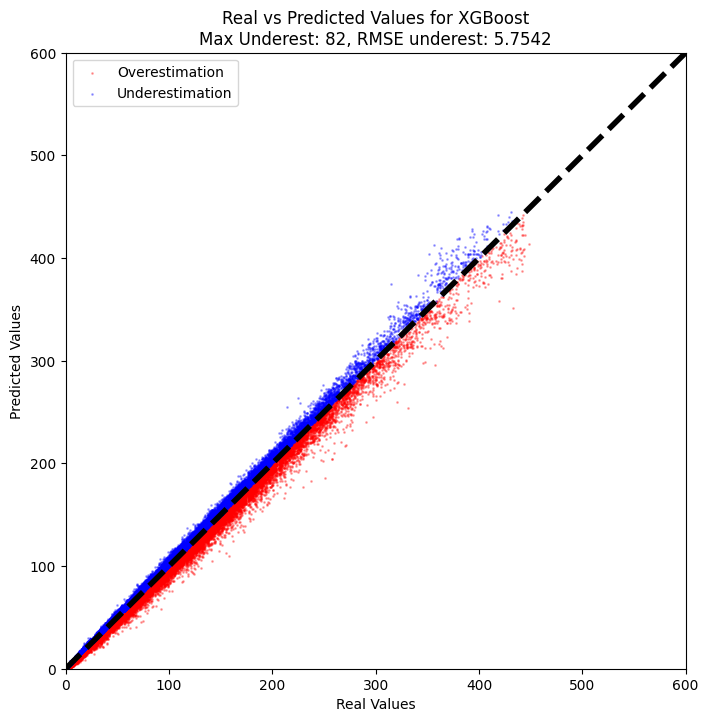

Decision Tree Test R-squared score: 0.9945215804100316
Decision Tree Test Mean Error: -0.029065625261439063
Decision Tree Test Root Mean Squared Error: 5.326996031688673
Decision Tree Test RMSE for underestimations: 6.175650038406415

Decision Tree Maximum underestimation for test data: 146.0
Decision Tree Maximum overestimation for test data: 149.0

Decision Tree Prediction time for 1000 instances: 0.00025238752365112303 seconds


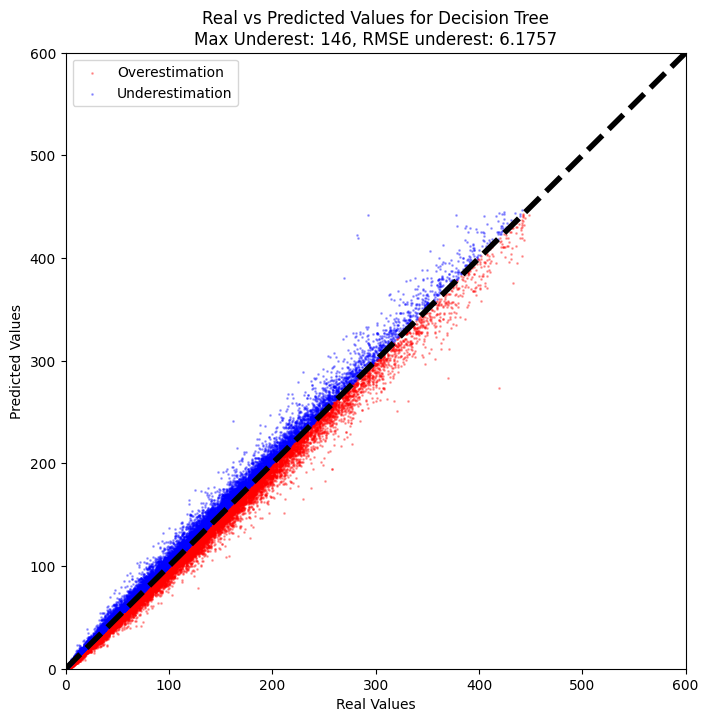

KNN Test R-squared score: 0.9941561106151051
KNN Test Mean Error: 0.43803484375
KNN Test Root Mean Squared Error: 5.501811678937065
KNN Test RMSE for underestimations: 7.325751690812027

KNN Maximum underestimation for test data: 177.671875
KNN Maximum overestimation for test data: 62.1875

KNN Prediction time for 1000 instances: 0.2344752812385559 seconds


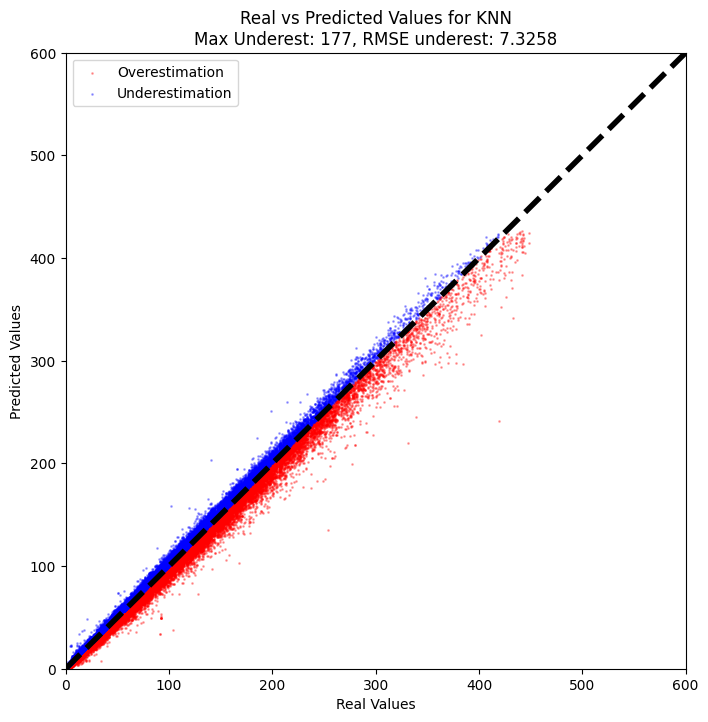

/Users/emanueleferrari/VSCode/SEC_Cleaner/CleanerSEC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Test R-squared score: 0.9962461884011882
Neural Network Test Mean Error: 0.09374101216868552
Neural Network Test Root Mean Squared Error: 4.409516412271092
Neural Network Test RMSE for underestimations: 5.983848245907337

Neural Network Maximum underestimation for test data: 95.30980755502588
Neural Network Maximum overestimation for test data: 30.73626515754114

Neural Network Prediction time for 1000 instances: 0.0016301417350769044 seconds


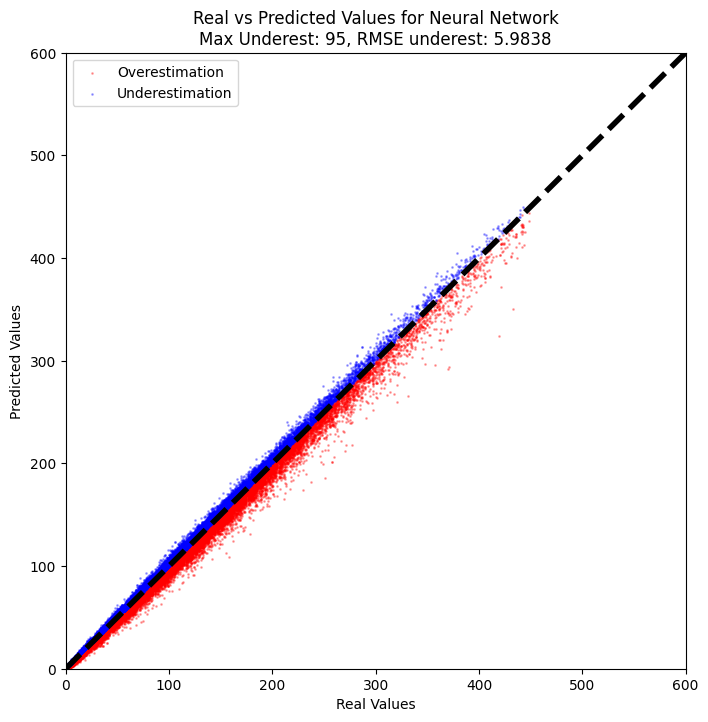

In [15]:
from sklearn.metrics import r2_score
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def train_models(model_dict, X_train, y_train, X_test, y_test):
    trained_models = {}

    pbar = tqdm(model_dict.items(), desc="Processing") 
    for model_name, model in pbar:        
        
        # Append classifier to preprocessing pipeline
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        # Fit the model to the training data
        clf.fit(X_train, y_train)

        # Start the timer
        start_time = time.time()

        # Predict the 'token_count' for the test data
        y_test_pred = clf.predict(X_test)

        # Stop the timer
        end_time = time.time()

        # Calculate the prediction time
        prediction_time = end_time - start_time

        # Calculate the R-squared score
        r2_test = r2_score(y_test, y_test_pred)

        # Calculate the Mean Absolute Error (MAE)
        mean_error = (y_test - y_test_pred).mean()

        # Calculate the Root Mean Squared Error (RMSE)
        rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

        # Calculate the RMSE of only the predictions that are less than the real values
        underestimations = y_test_pred < y_test
        rmse_underestimations = sqrt(mean_squared_error(y_test[underestimations], y_test_pred[underestimations]))

        # Calculate the variance of the squared errors
        squared_errors = (y_test - y_test_pred) ** 2
        variance_squared_errors = np.var(squared_errors)
        variance_squared_errors = variance_squared_errors**0.5

        # Calculate the maximum underestimation and overestimation
        underestimation_test = max(y_test - y_test_pred)
        overestimation_test = min(y_test - y_test_pred)*(-1)

        print(f'{model_name} Test R-squared score: {r2_test}')
        print(f'{model_name} Test Mean Error: {mean_error}')
        print(f'{model_name} Test Root Mean Squared Error: {rmse_test}')
        print(f'{model_name} Test RMSE for underestimations: {rmse_underestimations}')
        print()
        print(f'{model_name} Maximum underestimation for test data: {underestimation_test}')
        print(f'{model_name} Maximum overestimation for test data: {overestimation_test}')
        print()
        print(f'{model_name} Prediction time for 1000 instances: {prediction_time / (len(y_test) / 1000)} seconds')

        # Plot real vs predicted values
        plt.figure(figsize=(8, 8))
        # Create separate scatter plots for overestimations and underestimations
        underestimated = y_test < y_test_pred
        overestimated  = y_test >= y_test_pred
        plt.scatter(y_test[overestimated], y_test_pred[overestimated], color='red', alpha=0.3, s=1, label='Overestimation')
        plt.scatter(y_test[underestimated], y_test_pred[underestimated], color='blue', alpha=0.3, s=1, label='Underestimation')
        # Add the diagonal line
        plt.plot([0, 600], [0, 600], 'k--', lw=4)
        # Add labels and title
        plt.xlabel('Real Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Real vs Predicted Values for {model_name}\nMax Underest: {int(underestimation_test)}, RMSE underest: {round(rmse_underestimations, 4)}')
        
        # Set the x and y limits
        plt.xlim([0, 600])  # Set the maximum x value to 600
        plt.ylim([0, 600])  # Set the maximum y value to 600
        # Add the legend
        plt.legend()
        # Show the plot
        plt.show()

        # Store the trained model
        trained_models[model_name] = clf

    return trained_models

estimation_models = train_models(model_dict, X_train, y_train, X_test, y_test)

In [16]:
model = estimation_models['Linear Regression']

# Assuming that 'regressor' is the name of the Linear Regression step in your pipeline
linear_regression_model = model.named_steps['classifier']

coefficients = linear_regression_model.coef_
intercept = linear_regression_model.intercept_

# The rest of your code remains the same
features = ['char_count', 'word_count', 'sentence_count', 
            'punctuation_count', 'spaces_count', 'quotation_marks_count', 
            'special_char_count', 'unique_special_char_count',
            'unique_word_count', 'average_word_length', 
            'bigram_count', 'trigram_count']  # replace with your actual feature names

# Create a string representation of the formula
formula = "y = {:.2f}".format(intercept)
for feature, coef in zip(features, coefficients):
    formula += " + {:.2f}*{}".format(coef, feature)

print(formula)
print()

# Pair each feature with its coefficient
feature_coef_pairs = list(zip(features, coefficients))

# Sort the pairs by the absolute value of the coefficient in descending order
sorted_pairs = sorted(feature_coef_pairs, key=lambda pair: abs(pair[1]), reverse=True)

# Create a DataFrame from the sorted pairs
feature_importance_LR = pd.DataFrame(sorted_pairs, columns=['Feature', 'Coefficient'])

# Normalize the absolute coefficients by dividing each coefficient by the sum of all coefficients
normalized_importances = np.abs(feature_importance_LR['Coefficient']) / np.sum(np.abs(feature_importance_LR['Coefficient']))

# Add the normalized importances as a new column to the DataFrame
feature_importance_LR['NormalizedImportance'] = normalized_importances

# Display the DataFrame
display(feature_importance_LR)


y = 66.82 + 5.50*char_count + -1.91*word_count + 144.55*sentence_count + -0.57*punctuation_count + 98.90*spaces_count + 0.38*quotation_marks_count + 0.67*special_char_count + -93.94*unique_special_char_count + -1.36*unique_word_count + -0.59*average_word_length + -93.94*bigram_count + 12.78*trigram_count



,Feature,Coefficient,NormalizedImportance
0,sentence_count,144.550083,0.317629
1,spaces_count,98.900402,0.217320
2,bigram_count,-93.942042,0.206425
3,unique_special_char_count,-93.942042,0.206425
4,trigram_count,12.780522,0.028083
5,char_count,5.501696,0.012089
6,word_count,-1.912324,0.004202
7,unique_word_count,-1.360064,0.002989
8,special_char_count,0.667607,0.001467
9,average_word_length,-0.589602,0.001296


In [17]:
# Get the 'Linear Regression' model
model = estimation_models['Linear Regression']

# Predict the 'token_count' for the test, train, and eval data
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_eval_pred = model.predict(X_val)

# Calculate the underestimations and overestimations
overestimation_test = y_test - y_test_pred
underestimation_test = y_test_pred - y_test

overestimation_train  = y_train - y_train_pred
underestimation_train = y_train_pred - y_train

overestimation_eval  = y_val - y_eval_pred
underestimation_eval = y_eval_pred - y_val

# Convert underestimation and overestimation to DataFrame
underestimation_test_df = pd.DataFrame(underestimation_test)
overestimation_test_df = pd.DataFrame(overestimation_test)

underestimation_train_df = pd.DataFrame(underestimation_train)
overestimation_train_df = pd.DataFrame(overestimation_train)

underestimation_eval_df = pd.DataFrame(underestimation_eval)
overestimation_eval_df = pd.DataFrame(overestimation_eval)

# Attach the text from the corresponding DataFrame
underestimation_test_df['text'] = underestimation_test_df.index.map(X_test_df['text'])
overestimation_test_df['text'] = overestimation_test_df.index.map(X_test_df['text'])

underestimation_train_df['text'] = underestimation_train_df.index.map(X_train_df['text'])
overestimation_train_df['text'] = overestimation_train_df.index.map(X_train_df['text'])

underestimation_eval_df['text'] = underestimation_eval_df.index.map(X_val_df['text'])
overestimation_eval_df['text'] = overestimation_eval_df.index.map(X_val_df['text'])

# Print the top 10 underestimations and overestimations with text
for df, data_type in [(underestimation_test_df, 'test'), (underestimation_train_df, 'train'), (underestimation_eval_df, 'eval'),
                      (overestimation_test_df, 'test'), (overestimation_train_df, 'train'), (overestimation_eval_df, 'eval')]:
    print(f"\nTop 10 {'under' if df.iloc[0]['token_count'] < 0 else 'over'}estimations for {data_type} data:\n")
    for _, row in df.nlargest(10, df.columns[0]).iterrows():
        print(f"{row.iloc[0]}\n{row['text']}\n")
    print('\n', '_'*50, '\n')



Top 10 overestimations for test data:

58.74740868117084
_________________________________________________ _________ ______________________________________________

54.22397547839441
____________________________________________________________________________________________

54.22397547839441
____________________________________________________________________________________________

54.22397547839441
____________________________________________________________________________________________

54.22397547839441
____________________________________________________________________________________________

54.22397547839441
____________________________________________________________________________________________

45.84027230821971
2023 --------------------------------------------------------------------------------------- 2022

45.84027230821971
2023 --------------------------------------------------------------------------------------- 2022

35.398522623983126
The availability of a

In [18]:
model = estimation_models['XGBoost']

# Assuming that 'xgb' is the name of the XGBoost step in your pipeline
xgboost_model = model.named_steps['classifier']

# Get feature importances
importances = xgboost_model.feature_importances_

# Pair each feature with its importance
feature_importance_pairs = list(zip(features, importances))

# Create a DataFrame from the pairs
feature_importance_XGB = pd.DataFrame(feature_importance_pairs, columns=['Feature', 'Importance'])

# Sort the DataFrame by the importance in descending order
feature_importance_XGB = feature_importance_XGB.sort_values(by='Importance', ascending=False)

# Normalize the importances by dividing each importance by the sum of all importances
normalized_importances = feature_importance_XGB['Importance'] / feature_importance_XGB['Importance'].sum()


feature_importance_XGB.reset_index(drop=True, inplace=True)

# Display the DataFrame
display(feature_importance_XGB)

,Feature,Importance,NormalizedImportance
0,spaces_count,0.995834,0.996013
1,trigram_count,0.001234,0.001235
2,unique_special_char_count,0.000872,0.000872
3,quotation_marks_count,0.000447,0.000447
4,sentence_count,0.000290,0.000290
5,char_count,0.000246,0.000246
6,average_word_length,0.000232,0.000232
7,word_count,0.000195,0.000195
8,punctuation_count,0.000166,0.000166
9,unique_word_count,0.000154,0.000154


In [19]:
# Get the 'Linear Regression' model
model = estimation_models['XGBoost']

# Predict the 'token_count' for the test, train, and eval data
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_eval_pred = model.predict(X_val)

# Calculate the underestimations and overestimations
overestimation_test = y_test - y_test_pred
underestimation_test = y_test_pred - y_test

overestimation_train  = y_train - y_train_pred
underestimation_train = y_train_pred - y_train

overestimation_eval  = y_val - y_eval_pred
underestimation_eval = y_eval_pred - y_val

# Convert underestimation and overestimation to DataFrame
underestimation_test_df = pd.DataFrame(underestimation_test)
overestimation_test_df = pd.DataFrame(overestimation_test)

underestimation_train_df = pd.DataFrame(underestimation_train)
overestimation_train_df = pd.DataFrame(overestimation_train)

underestimation_eval_df = pd.DataFrame(underestimation_eval)
overestimation_eval_df = pd.DataFrame(overestimation_eval)

# Attach the text from the corresponding DataFrame
underestimation_test_df['text'] = underestimation_test_df.index.map(X_test_df['text'])
overestimation_test_df['text'] = overestimation_test_df.index.map(X_test_df['text'])

underestimation_train_df['text'] = underestimation_train_df.index.map(X_train_df['text'])
overestimation_train_df['text'] = overestimation_train_df.index.map(X_train_df['text'])

underestimation_eval_df['text'] = underestimation_eval_df.index.map(X_val_df['text'])
overestimation_eval_df['text'] = overestimation_eval_df.index.map(X_val_df['text'])

# Print the top 10 underestimations and overestimations with text
for df, data_type in [(underestimation_test_df, 'test'), (underestimation_train_df, 'train'), (underestimation_eval_df, 'eval'),
                      (overestimation_test_df, 'test'), (overestimation_train_df, 'train'), (overestimation_eval_df, 'eval')]:
    print(f"\nTop 10 {'under' if df.iloc[0]['token_count'] < 0 else 'over'}estimations for {data_type} data:\n")
    for _, row in df.nlargest(10, df.columns[0]).iterrows():
        print(f"{row.iloc[0]}\n{row['text']}\n")
    print('\n', '_'*50, '\n')


Top 10 overestimations for test data:

59.28045654296875
The following putative class action lawsuits were filed against Live Nation and/or Ticketmaster in the United States and Canada: Vaccaro v. Ticketmaster LLC (Northern District of Illinois, filed September 2018); Ameri v. Ticketmaster LLC (Northern District of California, filed September 2018); Lee v. Ticketmaster LLC, et al. (Northern District of California, filed September 2018); Thompson-Marcial v. Ticketmaster Canada Holdings ULC (Ontario Superior Court of Justice, filed September 2018); McPhee v. Live Nation Entertainment, Inc., et al. (Superior Court of Quebec, District of Montreal, filed September 2018); Crystal Watch v. Live Nation Entertainment, Inc., et al. (Court of Queen’s Bench for Saskatchewan, by amendments filed September 2018); Gaetano v. Live Nation Entertainment, Inc., et al. (Northern District of New York, filed October 2018); Dickey v. Ticketmaster LLC, et al. (Central District of California, filed October 20

In [20]:
# Get the 'Linear Regression' model
model = estimation_models['Neural Network']

# Predict the 'token_count' for the test, train, and eval data
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_eval_pred = model.predict(X_val)

# Calculate the underestimations and overestimations
overestimation_test = y_test - y_test_pred
underestimation_test = y_test_pred - y_test

overestimation_train  = y_train - y_train_pred
underestimation_train = y_train_pred - y_train

overestimation_eval  = y_val - y_eval_pred
underestimation_eval = y_eval_pred - y_val

# Convert underestimation and overestimation to DataFrame
underestimation_test_df = pd.DataFrame(underestimation_test)
overestimation_test_df = pd.DataFrame(overestimation_test)

underestimation_train_df = pd.DataFrame(underestimation_train)
overestimation_train_df = pd.DataFrame(overestimation_train)

underestimation_eval_df = pd.DataFrame(underestimation_eval)
overestimation_eval_df = pd.DataFrame(overestimation_eval)

# Attach the text from the corresponding DataFrame
underestimation_test_df['text'] = underestimation_test_df.index.map(X_test_df['text'])
overestimation_test_df['text'] = overestimation_test_df.index.map(X_test_df['text'])

underestimation_train_df['text'] = underestimation_train_df.index.map(X_train_df['text'])
overestimation_train_df['text'] = overestimation_train_df.index.map(X_train_df['text'])

underestimation_eval_df['text'] = underestimation_eval_df.index.map(X_val_df['text'])
overestimation_eval_df['text'] = overestimation_eval_df.index.map(X_val_df['text'])

# Print the top 10 underestimations and overestimations with text
for df, data_type in [(underestimation_test_df, 'test'), (underestimation_train_df, 'train'), (underestimation_eval_df, 'eval'),
                      (overestimation_test_df, 'test'), (overestimation_train_df, 'train'), (overestimation_eval_df, 'eval')]:
    print(f"\nTop 10 {'under' if df.iloc[0]['token_count'] < 0 else 'over'}estimations for {data_type} data:\n")
    for _, row in df.nlargest(10, df.columns[0]).iterrows():
        print(f"{row.iloc[0]}\n{row['text']}\n")
    print('\n', '_'*50, '\n')



Top 10 overestimations for test data:

30.73626515754114
The following putative class action lawsuits were filed against Live Nation and/or Ticketmaster in the United States and Canada: Vaccaro v. Ticketmaster LLC (Northern District of Illinois, filed September 2018); Ameri v. Ticketmaster LLC (Northern District of California, filed September 2018); Lee v. Ticketmaster LLC, et al. (Northern District of California, filed September 2018); Thompson-Marcial v. Ticketmaster Canada Holdings ULC (Ontario Superior Court of Justice, filed September 2018); McPhee v. Live Nation Entertainment, Inc., et al. (Superior Court of Quebec, District of Montreal, filed September 2018); Crystal Watch v. Live Nation Entertainment, Inc., et al. (Court of Queen’s Bench for Saskatchewan, by amendments filed September 2018); Gaetano v. Live Nation Entertainment, Inc., et al. (Northern District of New York, filed October 2018); Dickey v. Ticketmaster LLC, et al. (Central District of California, filed October 20

In [21]:
model = estimation_models['Neural Network']


from sklearn.inspection import permutation_importance


# perform permutation importance
results = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

# create a DataFrame with feature names and their importance
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importance
})

# sort the DataFrame based on the importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create a new column 'NormalizedImportance'
importance_df['NormalizedImportance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# reset the index of the DataFrame
importance_df.reset_index(drop=True, inplace=True)

# print the DataFrame
display(importance_df)

,Feature,Importance,NormalizedImportance
0,special_char_count,21747.323869,0.903196
1,char_count,1402.274093,0.058238
2,trigram_count,222.417974,0.009237
3,word_count,219.224149,0.009105
4,bigram_count,211.969810,0.008803
5,spaces_count,194.999502,0.008099
6,punctuation_count,32.758208,0.001360
7,average_word_length,22.966364,0.000954
8,word_mean_len_estim,10.728869,0.000446
9,unique_word_count,9.190711,0.000382


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all columns except 'text' and 'type'
selected_columns = [col for col in XY.columns if col not in ['text']]


selected_columns.append('char_over_spaces')

# Compute the correlation matrix
corr = XY[selected_columns].corr()

# Generate a mask for the diagonal
mask = np.eye(corr.shape[0]).astype(bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".3f")

plt.show()


KeyError: "['char_over_spaces'] not in index"

In [ ]:
# Create an empty list to store the pairs
high_corr_pairs = []

print('Perfectly correlated pairs:')
# Iterate over the correlation matrix
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) > 0.9999 :
            high_corr_pairs.append((corr.columns[i], corr.columns[j]))

# Print the pairs
for pair in high_corr_pairs:
    print(pair)# Create an empty list to store the pairs
high_corr_pairs = []

print()
print('Highly correlated pairs:')

# Iterate over the correlation matrix
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        temp = abs(corr.iloc[i, j])
        if temp > 0.99 and temp < 0.9999:
            high_corr_pairs.append((corr.columns[i], corr.columns[j]))

# Print the pairs
for pair in high_corr_pairs:
    print(pair)

Perfectly correlated pairs:
('word_count', 'spaces_count')
('word_count', 'bigram_count')
('word_count', 'trigram_count')
('spaces_count', 'bigram_count')
('spaces_count', 'trigram_count')
('bigram_count', 'trigram_count')

Highly correlated pairs:
('token_count', 'char_count')
('token_count', 'word_count')
('token_count', 'spaces_count')
('token_count', 'special_char_count')
('token_count', 'bigram_count')
('token_count', 'trigram_count')
('char_count', 'word_count')
('char_count', 'spaces_count')
('char_count', 'special_char_count')
('char_count', 'bigram_count')
('char_count', 'trigram_count')
('word_count', 'special_char_count')
('spaces_count', 'special_char_count')
('special_char_count', 'bigram_count')
('special_char_count', 'trigram_count')


In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add a node for each variable
for var in corr.columns:
    G.add_node(var)

# Add an edge for each pair of variables with correlation over 0.99
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) > 0.995:
            G.add_edge(corr.columns[i], corr.columns[j])

# Find connected components
components = list(nx.connected_components(G))

# Print the groups of variables
for component in components:
    print(component)

{'spaces_count', 'token_count', 'special_char_count', 'bigram_count', 'word_count', 'trigram_count', 'char_count'}
{'sentence_count'}
{'punctuation_count'}
{'quotation_marks_count'}
{'unique_special_char_count'}
{'unique_word_count'}
{'average_word_length'}
